# Import dependencies

In [ ]:
import numpy as np
from numpy.random import seed
import pandas as pd

# Pickle
import pickle

# Per confronto finale
from numpy.core.fromnumeric import size

# Metriche e matrice di confusione
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, multilabel_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Image management
from skimage import io
from skimage.color.colorconv import rgb2gray
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
from keras import layers, regularizers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.layers import Input, Flatten, Dense, Dropout, Reshape, Resizing, Rescaling, LeakyReLU, Lambda, Concatenate

!pip install visualkeras
import visualkeras

from sklearn.model_selection import train_test_split

import os
import re
import random

from os import path

import cv2 as cv
import matplotlib.pyplot as plt

from google.colab import files

# Seeds all randoms
cherrypicked_seed = 420
seed(cherrypicked_seed)
tf.random.set_seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Conntect to gDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download dataset from kaggle

- Dataset [ https://www.kaggle.com/datasets/gpiosenka/yikes-spiders-15-species ]
- Kaggle API instructions [ https://www.kaggle.com/general/74235 ] 

In [ ]:
! pip install -q kaggle
from google.colab import files

# upload kaggle.json
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
# !cp /content/drive/MyDrive/AML_Progetto/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download 'gpiosenka/yikes-spiders-15-species'

import zipfile
with zipfile.ZipFile('yikes-spiders-15-species.zip', 'r') as zip_ref:
    zip_ref.extractall('yikes')

Saving kaggle.json to kaggle.json
 99% 57.0M/57.5M [00:04<00:00, 15.8MB/s]
100% 57.5M/57.5M [00:04<00:00, 14.2MB/s]


# Load and prepare data

In [ ]:
base_path = 'yikes/'
target_shape = (224,224,3)
labels = os.listdir(base_path + 'train')
labels_dict = {lb:i for i, lb in enumerate(labels)}
n_classes = len(labels)

In [ ]:
labels

['Brown Grass Spider',
 'Brown Recluse Spider',
 'Blue Tarantula',
 'Ladybird Mimic Spider',
 'White Kneed Tarantula',
 'Huntsman Spider',
 'Bold Jumper',
 'Hobo Spider',
 'Golden Orb Weaver',
 'Red Knee Tarantula',
 'Deinopis Spider',
 'Yellow Garden Spider',
 'Peacock Spider',
 'Spiny-backed Orb-weaver',
 'Black Widow']

In [ ]:
train_entries = [[base_path+'train/'+label+'/'+filename, label] for label in os.listdir(base_path + 'train/') for filename in os.listdir(base_path + 'train/' + label)]
test_entries = [[base_path+'test/'+label+'/'+filename, label] for label in os.listdir(base_path + 'test/') for filename in os.listdir(base_path + 'test/' + label)]

entries = train_entries + test_entries
df = pd.DataFrame(entries, columns=['filename', 'label'])

label_dict = {lb:ilb for ilb,lb in enumerate(list(set(df.label)))}
df['int_label'] = df.label.apply(lambda lb: labels_dict[lb])

##Visualize the data 

## Check class imbalance

In [ ]:
fig = px.histogram(df.label,title='Class distribution',color=df.label)
fig.show()

## Split Train - Validation - Test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.filename, df.int_label, test_size=0.1, stratify=df.int_label, random_state=cherrypicked_seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train, random_state=cherrypicked_seed)

yc_train = keras.utils.to_categorical(y_train, n_classes)
yc_val = keras.utils.to_categorical(y_val, n_classes)
yc_test = keras.utils.to_categorical(y_test, n_classes)

# Build Models

## Utils

In [ ]:
def save_pkl(filename, obj):
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)
  return filename

def load_pkl(filename):
  with open(filename, 'rb') as f:
    obj = pickle.load(f)
  return obj

def build_augmentation_section(flip_mode = 'horizontal_and_vertical', rotation_range = 0.2):
  data_augmentation = Sequential([
    layers.RandomFlip(mode = flip_mode),
    layers.RandomRotation(rotation_range),
    # tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.5, 0.5), width_factor=(-0.5, 0.5), interpolation="bilinear", fill_mode="constant", fill_value=255.0, seed=cherrypicked_seed),
    # tf.keras.layers.RandomBrightness((-0.25, 0.25), value_range=(0, 255), seed=cherrypicked_seed),
    # tf.keras.layers.RandomContrast(0.25, seed=cherrypicked_seed)
  ])
  return data_augmentation

def build_input_section(inputs, preprocess_input_layer, do_normalization = False, do_augmentation = True):
  if do_normalization:
    inputs = Rescaling(1./255)(inputs)
  if do_augmentation:
    inputs = build_augmentation_section()(inputs)
  outputs = preprocess_input_layer(inputs)
  return outputs

def build_output_section(inputs, n_classes, activation = 'relu', output_activation = 'softmax'):
  x = layers.GlobalAveragePooling2D()(inputs) 
  x = Dense(512, activation = activation, kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(x)
  x = Dropout(0.2)(x)
  x = Dense(256, activation = activation, kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(x)
  x = Dropout(0.1)(x)
  x = Dense(128, activation = activation, kernel_regularizer = regularizers.l2(), bias_regularizer= regularizers.l2())(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation = activation)(x)
  outputs = Dense(n_classes, activation = output_activation)(x)
  return outputs

def trim_model(model, layer_name): 
  return Model(inputs = model.input, outputs = model.get_layer(layer_name).output)

def freeze_model(model, freeze_until_layer=None):
  freeze_until_idx = [i for i,layer in enumerate(model.layers) if layer.name==freeze_until_layer][0] if freeze_until_layer!=None else len(model.layers)+1
  for layer_idx,layer in enumerate(model.layers):
    layer.trainable = False if layer_idx <= freeze_until_idx else True
  return model

def plot_history(history): 
  fig = make_subplots(rows = 1, cols = 2, subplot_titles = ["Loss", "Accuracy"]) 
  fig.add_trace(go.Scatter(y = history.history['val_loss'], name = "val_loss"), row = 1, col = 1,) 
  fig.add_trace(go.Scatter(y = history.history['loss'], name = "loss"), row = 1, col = 1,) 
  fig.add_trace(go.Scatter(y = history.history['val_accuracy'], name = "val accuracy"), row = 1, col = 2,) 
  fig.add_trace(go.Scatter(y = history.history['accuracy'], name = "accuracy"), row = 1, col = 2,) 
  # Set x-axis title 
  fig.update_xaxes(title_text = "Epoch") 
  # Set y-axes titles 
  fig.update_yaxes(title_text = "Loss", row = 1, col = 1) 
  fig.update_yaxes(title_text = "Accuracy", row = 1, col = 2) 
  fig.show()

## Resnet50

In [ ]:
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input as ResNet50_preprocess_input

In [ ]:
resnet50 = ResNet50(include_top = False, weights = "imagenet", input_shape = target_shape)

94765736/94765736 [==============================] - 7s 0us/step


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

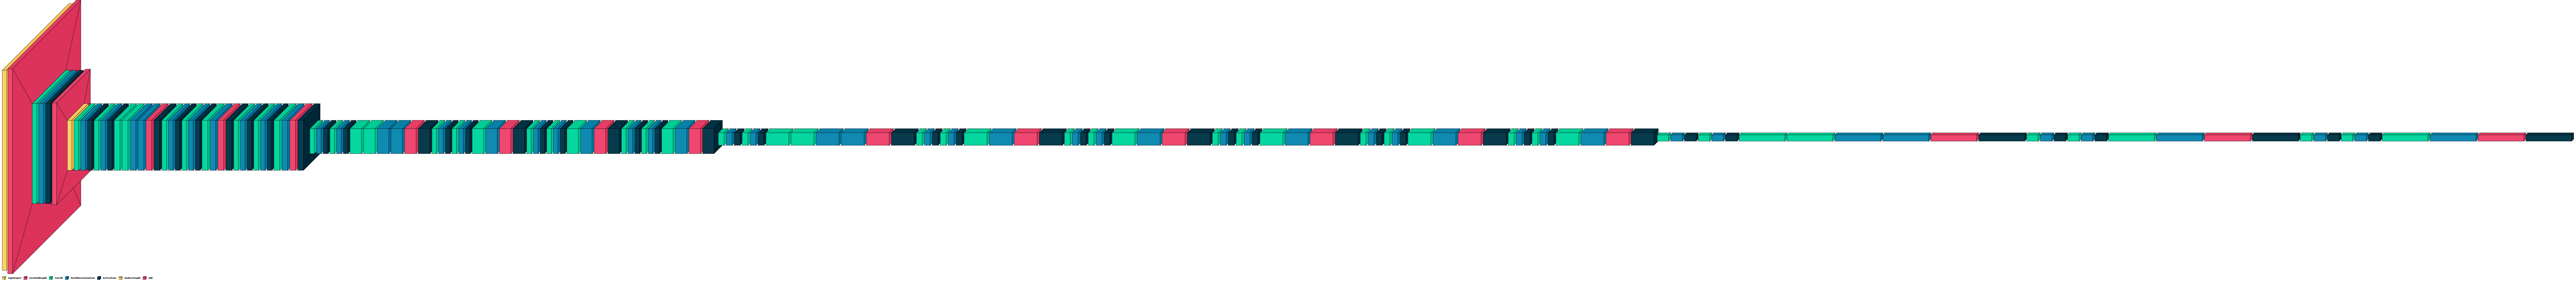

In [ ]:
resnet50.summary()
visualkeras.layered_view(resnet50, legend = True)

In [ ]:
trim_layer = 'conv5_block3_out'
resnet50_basenet = freeze_model(trim_model(resnet50, trim_layer), freeze_until_layer='conv4_block6_out')

inputs = Input(shape = target_shape)
model = build_input_section(inputs, ResNet50_preprocess_input, False, True)
model = resnet50_basenet(model)
outputs = build_output_section(model, n_classes)

resnet50_net = Model(inputs, outputs)

resnet50_net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 model (Functional)          (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                    

## EfficientNetV2B3

In [ ]:
from keras.applications import EfficientNetV2B3
from keras.applications.efficientnet_v2 import preprocess_input as EfficientNetV2B3_preprocess_input

In [ ]:
efficientNetV2B3 = EfficientNetV2B3(include_top = False, weights = "imagenet", input_shape = (224, 224, 3))

52606240/52606240 [==============================] - 3s 0us/step


Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 40  1080        ['normalization[0

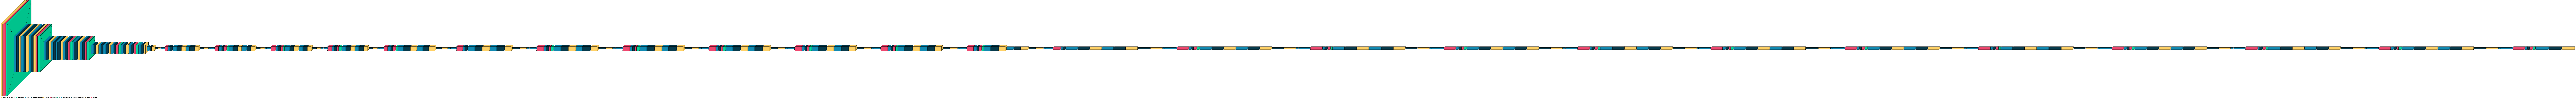

In [ ]:
efficientNetV2B3.summary()
visualkeras.layered_view(efficientNetV2B3, legend = True)

In [ ]:
trim_layer = 'top_activation'
efficientNetV2B3_basenet = freeze_model(trim_model(efficientNetV2B3, trim_layer), freeze_until_layer='block4e_add')

inputs = Input(shape = target_shape)
model = build_input_section(inputs, EfficientNetV2B3_preprocess_input, False, True)
model = efficientNetV2B3_basenet(model)
outputs = build_output_section(model, n_classes)

efficientNetV2B3_net = Model(inputs, outputs)

efficientNetV2B3_net.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 model_2 (Functional)        (None, 7, 7, 1536)        12930622  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 512)               786944    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                           

## Xception

In [ ]:
from keras.applications import Xception
from keras.applications.xception import preprocess_input as Xception_preprocess_input

In [ ]:
xception = Xception(include_top = False, weights = "imagenet", input_shape = (224, 224, 3))

83683744/83683744 [==============================] - 4s 0us/step


Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

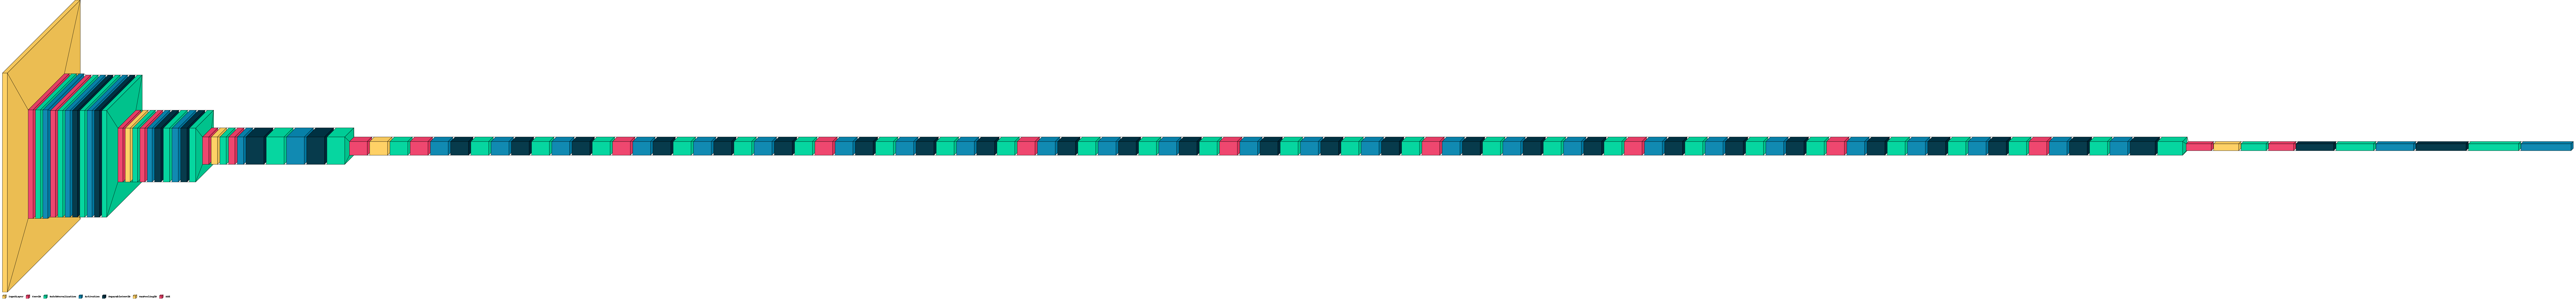

In [ ]:
xception.summary()
visualkeras.layered_view(xception, legend = True)

In [ ]:
trim_layer = 'block14_sepconv2_act'
xception_basenet = freeze_model(trim_model(xception, trim_layer), freeze_until_layer='add_9')

inputs = Input(shape = target_shape)
model = build_input_section(inputs, Xception_preprocess_input, False, True)
model = xception_basenet(model)
outputs = build_output_section(model, n_classes)

xception_net = Model(inputs, outputs)

xception_net.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 model_4 (Functional)        (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

# Train

## Prepare inputs

In [ ]:
train_imgs = np.stack([io.imread(fn) for fn in x_train])
val_imgs = np.stack([io.imread(fn) for fn in x_val])
test_imgs = np.stack([io.imread(fn) for fn in x_test])

## Resnet50

In [ ]:
resnet50_net.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 5,
        restore_best_weights = True
    )
]

resnet50_net_hist = resnet50_net.fit(train_imgs, yc_train,
                                         validation_data = (val_imgs, yc_val),
                                         epochs = 50,
                                         batch_size=32,
                                         callbacks = callbacks)

Epoch 1/50
58/58 [==============================] - 25s 213ms/step - loss: 9.7548 - accuracy: 0.5891 - val_loss: 97.7038 - val_accuracy: 0.2843
Epoch 2/50
58/58 [==============================] - 10s 169ms/step - loss: 4.1844 - accuracy: 0.7536 - val_loss: 9.0950 - val_accuracy: 0.3971
Epoch 3/50
58/58 [==============================] - 10s 171ms/step - loss: 2.4999 - accuracy: 0.8098 - val_loss: 2.1358 - val_accuracy: 0.8431
Epoch 4/50
58/58 [==============================] - 10s 176ms/step - loss: 1.8721 - accuracy: 0.8339 - val_loss: 1.8813 - val_accuracy: 0.8039
Epoch 5/50
58/58 [==============================] - 10s 178ms/step - loss: 1.4277 - accuracy: 0.8579 - val_loss: 1.7259 - val_accuracy: 0.7794
Epoch 6/50
58/58 [==============================] - 10s 176ms/step - loss: 1.2734 - accuracy: 0.8448 - val_loss: 1.5456 - val_accuracy: 0.7696
Epoch 7/50
58/58 [==============================] - 10s 180ms/step - loss: 1.0492 - accuracy: 0.8639 - val_loss: 1.3892 - val_accuracy: 0.813

In [ ]:
plot_history(resnet50_net_hist)

In [ ]:
resnet50_net.evaluate(test_imgs, yc_test)

8/8 [==============================] - 1s 140ms/step - loss: 0.4670 - accuracy: 0.9071


[0.46703973412513733, 0.9070796370506287]

### Fine tune

compile the model and start training it

In [ ]:
resnet50_net.trainable = True

In [ ]:
base_learning_rate = 0.0001
resnet50_net.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 3,
        restore_best_weights = True
    )
]

start_finetune_epoch = resnet50_net_hist.epoch[-1]
initial_epochs = len(resnet50_net_hist.epoch)
total_epochs = initial_epochs+10

resnet50_net_finetune_hist = resnet50_net.fit(train_imgs, yc_train,
                                        validation_data = (val_imgs, yc_val),
                                        epochs=total_epochs,
                                        initial_epoch=start_finetune_epoch,
                                        batch_size=32,
                                        callbacks = callbacks)

Epoch 27/37
58/58 [==============================] - 30s 405ms/step - loss: 0.4043 - accuracy: 0.9311 - val_loss: 0.7522 - val_accuracy: 0.8333
Epoch 28/37
58/58 [==============================] - 22s 380ms/step - loss: 0.3380 - accuracy: 0.9519 - val_loss: 0.5605 - val_accuracy: 0.8725
Epoch 29/37
58/58 [==============================] - 21s 370ms/step - loss: 0.3089 - accuracy: 0.9617 - val_loss: 0.6514 - val_accuracy: 0.8725
Epoch 30/37
58/58 [==============================] - 22s 375ms/step - loss: 0.3175 - accuracy: 0.9557 - val_loss: 0.5785 - val_accuracy: 0.8775
Epoch 31/37
58/58 [==============================] - 22s 373ms/step - loss: 0.3172 - accuracy: 0.9536 - val_loss: 0.8529 - val_accuracy: 0.8480


In [ ]:
plot_history(resnet50_net_finetune_hist)

In [ ]:
resnet50_net.evaluate(test_imgs, yc_test)

8/8 [==============================] - 1s 85ms/step - loss: 0.5526 - accuracy: 0.8850


[0.552605152130127, 0.8849557638168335]

## EfficientNetV2B3

In [ ]:
efficientNetV2B3_net.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 5,
        restore_best_weights = True
    )
]

efficientNetV2B3_net_hist = efficientNetV2B3_net.fit(train_imgs, yc_train,
                                                        validation_data = (val_imgs, yc_val),
                                                        epochs = 50,
                                                        batch_size=32,
                                                        callbacks = callbacks)

Epoch 1/50
58/58 [==============================] - 36s 341ms/step - loss: 8.3938 - accuracy: 0.5377 - val_loss: 4.0422 - val_accuracy: 0.7206
Epoch 2/50
58/58 [==============================] - 15s 257ms/step - loss: 2.9659 - accuracy: 0.7120 - val_loss: 2.0574 - val_accuracy: 0.8088
Epoch 3/50
58/58 [==============================] - 15s 257ms/step - loss: 1.7484 - accuracy: 0.7765 - val_loss: 1.3583 - val_accuracy: 0.8186
Epoch 4/50
58/58 [==============================] - 15s 259ms/step - loss: 1.4201 - accuracy: 0.7852 - val_loss: 1.1018 - val_accuracy: 0.8431
Epoch 5/50
58/58 [==============================] - 15s 251ms/step - loss: 1.0558 - accuracy: 0.8317 - val_loss: 0.8988 - val_accuracy: 0.8627
Epoch 6/50
58/58 [==============================] - 14s 248ms/step - loss: 0.9565 - accuracy: 0.8355 - val_loss: 0.9298 - val_accuracy: 0.8431
Epoch 7/50
58/58 [==============================] - 14s 249ms/step - loss: 0.9393 - accuracy: 0.8295 - val_loss: 0.9062 - val_accuracy: 0.8039

In [ ]:
plot_history(efficientNetV2B3_net_hist)

In [ ]:
efficientNetV2B3_net.evaluate(test_imgs, yc_test)

8/8 [==============================] - 1s 136ms/step - loss: 0.4628 - accuracy: 0.8850


[0.46275338530540466, 0.8849557638168335]

### Fine tune

In [ ]:
efficientNetV2B3_net.trainable = True

In [ ]:
base_learning_rate = 0.0001
efficientNetV2B3_net.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 7,
        restore_best_weights = True
    )
]

start_finetune_epoch = efficientNetV2B3_net_hist.epoch[-1]
initial_epochs = len(efficientNetV2B3_net_hist.epoch)
total_epochs = initial_epochs+30

efficientNetV2B3_net_finetune_hist = efficientNetV2B3_net.fit(train_imgs, yc_train,
                                                        validation_data = (val_imgs, yc_val),
                                                        epochs=total_epochs,
                                                        initial_epoch=start_finetune_epoch,
                                                        batch_size=32,
                                                        callbacks = callbacks)

Epoch 21/51
58/58 [==============================] - 43s 423ms/step - loss: 0.4544 - accuracy: 0.9142 - val_loss: 0.5264 - val_accuracy: 0.8676
Epoch 22/51
58/58 [==============================] - 21s 362ms/step - loss: 0.4115 - accuracy: 0.9120 - val_loss: 0.4561 - val_accuracy: 0.9020
Epoch 23/51
58/58 [==============================] - 21s 362ms/step - loss: 0.3712 - accuracy: 0.9344 - val_loss: 0.4261 - val_accuracy: 0.8971
Epoch 24/51
58/58 [==============================] - 20s 351ms/step - loss: 0.3766 - accuracy: 0.9240 - val_loss: 0.4261 - val_accuracy: 0.8873
Epoch 25/51
58/58 [==============================] - 21s 360ms/step - loss: 0.3460 - accuracy: 0.9361 - val_loss: 0.4283 - val_accuracy: 0.8971
Epoch 26/51
58/58 [==============================] - 21s 356ms/step - loss: 0.3364 - accuracy: 0.9339 - val_loss: 0.4452 - val_accuracy: 0.8971
Epoch 27/51
58/58 [==============================] - 21s 356ms/step - loss: 0.3258 - accuracy: 0.9366 - val_loss: 0.4310 - val_accuracy:

In [ ]:
plot_history(efficientNetV2B3_net_finetune_hist)

In [ ]:
efficientNetV2B3_net.evaluate(test_imgs, yc_test)

8/8 [==============================] - 1s 77ms/step - loss: 0.3415 - accuracy: 0.9425


[0.3414818048477173, 0.9424778819084167]

## Xception

In [ ]:
xception_net.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 5,
        restore_best_weights = True
    )
]

xception_net_hist = xception_net.fit(train_imgs, yc_train,
                                         validation_data = (val_imgs, yc_val),
                                         epochs = 50,
                                         batch_size = 32,
                                         callbacks = callbacks)

Epoch 1/50
58/58 [==============================] - 21s 279ms/step - loss: 7.6527 - accuracy: 0.4934 - val_loss: 3.4759 - val_accuracy: 0.6814
Epoch 2/50
58/58 [==============================] - 14s 237ms/step - loss: 2.4498 - accuracy: 0.7497 - val_loss: 2.1746 - val_accuracy: 0.7059
Epoch 3/50
58/58 [==============================] - 14s 243ms/step - loss: 1.6389 - accuracy: 0.7814 - val_loss: 1.9869 - val_accuracy: 0.7059
Epoch 4/50
58/58 [==============================] - 13s 232ms/step - loss: 1.2880 - accuracy: 0.8240 - val_loss: 1.4339 - val_accuracy: 0.7255
Epoch 5/50
58/58 [==============================] - 13s 230ms/step - loss: 1.1511 - accuracy: 0.8246 - val_loss: 1.2628 - val_accuracy: 0.7549
Epoch 6/50
58/58 [==============================] - 13s 228ms/step - loss: 0.9933 - accuracy: 0.8519 - val_loss: 0.9919 - val_accuracy: 0.8431
Epoch 7/50
58/58 [==============================] - 14s 238ms/step - loss: 0.9191 - accuracy: 0.8530 - val_loss: 0.9081 - val_accuracy: 0.8529

In [ ]:
plot_history(xception_net_hist)

In [ ]:
xception_net.evaluate(test_imgs, yc_test)

8/8 [==============================] - 1s 184ms/step - loss: 0.5091 - accuracy: 0.9159


[0.5091246962547302, 0.9159291982650757]

### Fine tune

In [ ]:
xception_net.trainable = True

In [ ]:
base_learning_rate = 0.0001
xception_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 3,
        restore_best_weights = True
    )
]

start_finetune_epoch = xception_net_hist.epoch[-1]
initial_epochs = len(xception_net_hist.epoch)
total_epochs = initial_epochs+10

xception_net_finetune_hist = xception_net.fit(train_imgs, yc_train,
                                        validation_data = (val_imgs, yc_val),
                                        epochs=total_epochs,
                                        initial_epoch=start_finetune_epoch,
                                        batch_size=32,
                                        callbacks = callbacks)

Epoch 47/57
58/58 [==============================] - 47s 694ms/step - loss: 0.3375 - accuracy: 0.9574 - val_loss: 0.5107 - val_accuracy: 0.9216
Epoch 48/57
58/58 [==============================] - 38s 651ms/step - loss: 0.2628 - accuracy: 0.9705 - val_loss: 0.4391 - val_accuracy: 0.9412
Epoch 49/57
58/58 [==============================] - 38s 650ms/step - loss: 0.2377 - accuracy: 0.9738 - val_loss: 0.3954 - val_accuracy: 0.9314
Epoch 50/57
58/58 [==============================] - 38s 655ms/step - loss: 0.2221 - accuracy: 0.9787 - val_loss: 0.4866 - val_accuracy: 0.8971
Epoch 51/57
58/58 [==============================] - 38s 651ms/step - loss: 0.1968 - accuracy: 0.9814 - val_loss: 0.3916 - val_accuracy: 0.9363
Epoch 52/57
58/58 [==============================] - 38s 653ms/step - loss: 0.2050 - accuracy: 0.9820 - val_loss: 0.4059 - val_accuracy: 0.9412
Epoch 53/57
58/58 [==============================] - 38s 654ms/step - loss: 0.2018 - accuracy: 0.9809 - val_loss: 0.3892 - val_accuracy:

In [ ]:
plot_history(xception_net_finetune_hist)

In [ ]:
xception_net.evaluate(test_imgs, yc_test)

8/8 [==============================] - 1s 117ms/step - loss: 0.3227 - accuracy: 0.9292


[0.32267218828201294, 0.9292035102844238]

# Evaluation

In [ ]:
def get_predictions(model, x, do_argmax=True):
    y_pred = model.predict(x)
    if do_argmax:
        y_pred = np.argmax(y_pred, axis=1)
    return y_pred

# Confusion matrix
def plot_cm(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(7,7))
    plt.xlabel('Ground truth');
    plt.ylabel('Prediction');
    plt.show()

## Resnet50

8/8 [==============================] - 2s 90ms/step


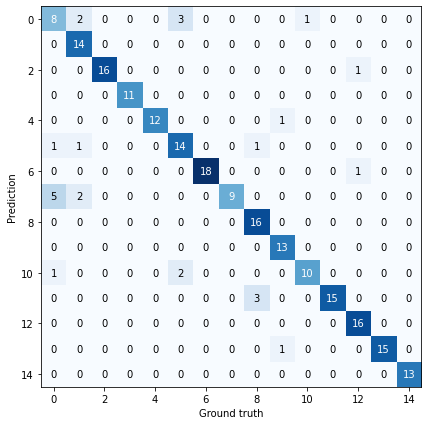

              precision    recall  f1-score   support

           0       0.53      0.57      0.55        14
           1       0.74      1.00      0.85        14
           2       1.00      0.94      0.97        17
           3       1.00      1.00      1.00        11
           4       1.00      0.92      0.96        13
           5       0.74      0.82      0.78        17
           6       1.00      0.95      0.97        19
           7       1.00      0.56      0.72        16
           8       0.80      1.00      0.89        16
           9       0.87      1.00      0.93        13
          10       0.91      0.77      0.83        13
          11       1.00      0.83      0.91        18
          12       0.89      1.00      0.94        16
          13       1.00      0.94      0.97        16
          14       1.00      1.00      1.00        13

    accuracy                           0.88       226
   macro avg       0.90      0.89      0.88       226
weighted avg       0.90   

In [ ]:
y_pred = get_predictions(resnet50_net, test_imgs)

plot_cm(y_test, y_pred)
print(classification_report(y_test, y_pred))

Classi più confuse: n.2 e n.14 (anche tra di loro)

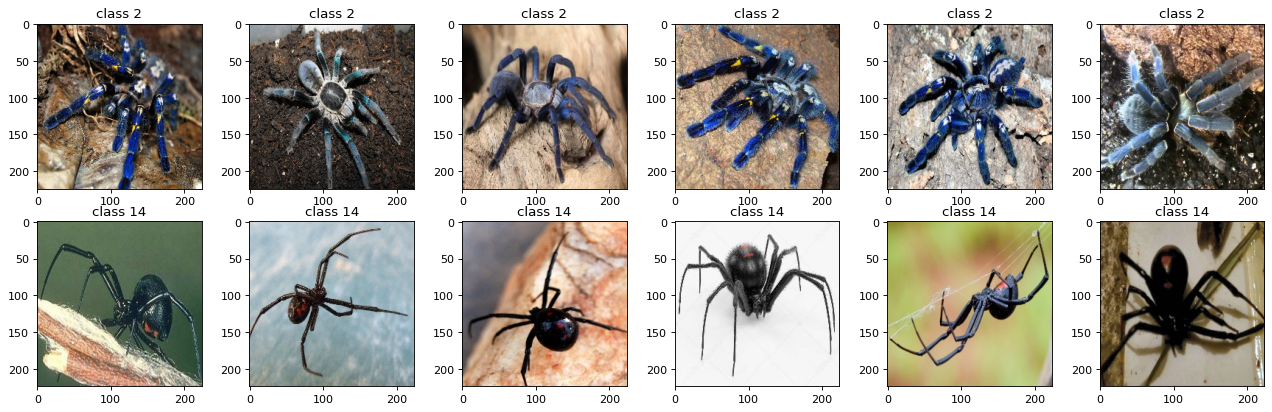

In [ ]:
plt.figure(figsize=(20, 6), dpi=80)

plt.subplot(2,6,1); plt.imshow(io.imread(df[df.int_label==2].filename.iloc[0])); plt.title('class 2')
plt.subplot(2,6,2); plt.imshow(io.imread(df[df.int_label==2].filename.iloc[1])); plt.title('class 2')
plt.subplot(2,6,3); plt.imshow(io.imread(df[df.int_label==2].filename.iloc[2])); plt.title('class 2')
plt.subplot(2,6,4); plt.imshow(io.imread(df[df.int_label==2].filename.iloc[3])); plt.title('class 2')
plt.subplot(2,6,5); plt.imshow(io.imread(df[df.int_label==2].filename.iloc[4])); plt.title('class 2')
plt.subplot(2,6,6); plt.imshow(io.imread(df[df.int_label==2].filename.iloc[5])); plt.title('class 2')

plt.subplot(2,6,7); plt.imshow(io.imread(df[df.int_label==14].filename.iloc[1])); plt.title('class 14')
plt.subplot(2,6,8); plt.imshow(io.imread(df[df.int_label==14].filename.iloc[2])); plt.title('class 14')
plt.subplot(2,6,9); plt.imshow(io.imread(df[df.int_label==14].filename.iloc[3])); plt.title('class 14')
plt.subplot(2,6,10); plt.imshow(io.imread(df[df.int_label==14].filename.iloc[4])); plt.title('class 14')
plt.subplot(2,6,11); plt.imshow(io.imread(df[df.int_label==14].filename.iloc[6])); plt.title('class 14')
plt.subplot(2,6,12); plt.imshow(io.imread(df[df.int_label==14].filename.iloc[7])); plt.title('class 14')

plt.show()

## EfficientNetV2B3

8/8 [==============================] - 3s 85ms/step


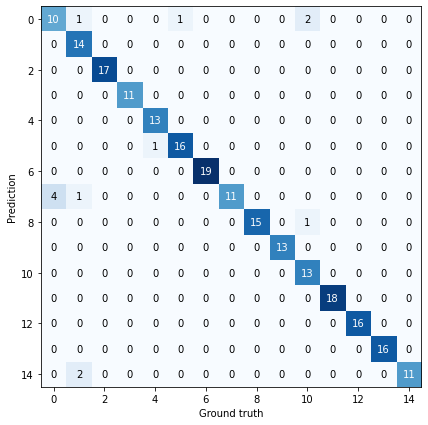

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.78      1.00      0.88        14
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        11
           4       0.93      1.00      0.96        13
           5       0.94      0.94      0.94        17
           6       1.00      1.00      1.00        19
           7       1.00      0.69      0.81        16
           8       1.00      0.94      0.97        16
           9       1.00      1.00      1.00        13
          10       0.81      1.00      0.90        13
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        16
          14       1.00      0.85      0.92        13

    accuracy                           0.94       226
   macro avg       0.94      0.94      0.94       226
weighted avg       0.95   

In [ ]:
y_pred = get_predictions(efficientNetV2B3_net, test_imgs)

plot_cm(y_test, y_pred)
print(classification_report(y_test, y_pred))

## Xception

8/8 [==============================] - 2s 133ms/step


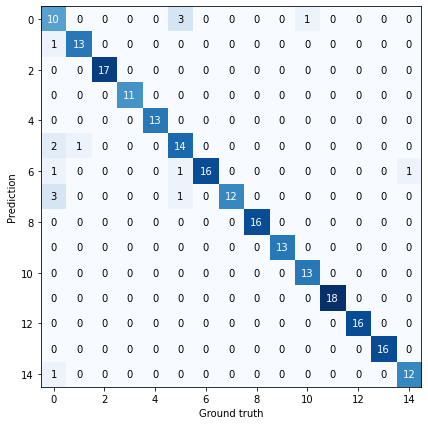

              precision    recall  f1-score   support

           0       0.56      0.71      0.63        14
           1       0.93      0.93      0.93        14
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        13
           5       0.74      0.82      0.78        17
           6       1.00      0.84      0.91        19
           7       1.00      0.75      0.86        16
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        13
          10       0.93      1.00      0.96        13
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        16
          14       0.92      0.92      0.92        13

    accuracy                           0.93       226
   macro avg       0.94      0.93      0.93       226
weighted avg       0.94   

In [ ]:
y_pred = get_predictions(xception_net, test_imgs)

plot_cm(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Ensemble modeling

Resnet50 + EfficientNetV2B3 + Xception

## Get predictions

In [ ]:
y_pred_resnet50_net = get_predictions(resnet50_net, test_imgs, do_argmax=False)
y_pred_efficientNetV2B3_net = get_predictions(efficientNetV2B3_net, test_imgs, do_argmax=False)
y_pred_xception_net = get_predictions(xception_net, test_imgs, do_argmax=False)

8/8 [==============================] - 1s 135ms/step


## Combine predictions

Final predicion is given by the mean over Resnet50, EfficientNetV2B3 and Xception predictions

In [ ]:
combine1_mean = lambda *preds: np.sum((preds), axis=0) / 3

In [ ]:
y_pred_combined = np.stack([np.argmax(combine1_mean(yp_resnet50, yp_efficientNetV2B3, yp_xception)) for yp_resnet50, yp_efficientNetV2B3, yp_xception in zip(y_pred_resnet50_net, y_pred_xception_net, y_pred_efficientNetV2B3_net)])

## Evaluation

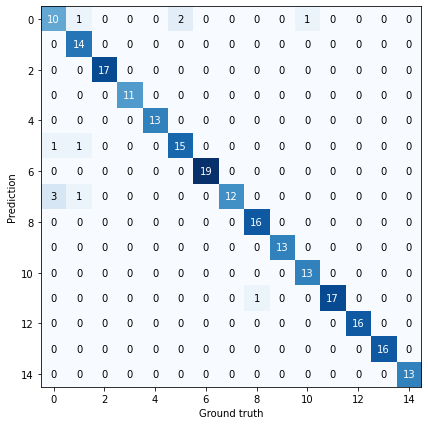

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        14
           1       0.82      1.00      0.90        14
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        13
           5       0.88      0.88      0.88        17
           6       1.00      1.00      1.00        19
           7       1.00      0.75      0.86        16
           8       0.94      1.00      0.97        16
           9       1.00      1.00      1.00        13
          10       0.93      1.00      0.96        13
          11       1.00      0.94      0.97        18
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        16
          14       1.00      1.00      1.00        13

    accuracy                           0.95       226
   macro avg       0.95      0.95      0.95       226
weighted avg       0.95   

In [ ]:
plot_cm(y_test, y_pred_combined)
print(classification_report(y_test, y_pred_combined))

# Backup pickle models 

## Save

In [ ]:
# Resnet50
_ = save_pkl('resnet50_net.pickle', resnet50_net)
_ = save_pkl('resnet50_net_hist.pickle', resnet50_net_hist)
_ = save_pkl('resnet50_net_finetuen_hist.pickle', resnet50_net_finetune_hist)

# EfficientNetV2B3
_ = save_pkl('efficientNetV2B3_net.pickle', efficientNetV2B3_net)
_ = save_pkl('efficientNetV2B3_net_hist.pickle', efficientNetV2B3_net_hist)
_ = save_pkl('efficientNetV2B3_net_finetune_hist.pickle', efficientNetV2B3_net_finetune_hist)

# Xception
_ = save_pkl('xception_net.pickle', xception_net)
_ = save_pkl('xception_net_hist.pickle', xception_net_hist)
_ = save_pkl('xception_net_finetuen_hist.pickle', xception_net_finetune_hist)

## Load

*Connect to gDrive is required*

In [ ]:
# Base path to pickle objects - modify with yours
models_folder_path = '/content/drive/MyDrive/Progetto/Images_pickle/'

# Resnet50
resnet50_net = load_pkl(models_folder_path + 'resnet50_net.pickle')
resnet50_net_hist = load_pkl(models_folder_path + 'resnet50_net_hist.pickle')
resnet50_net_finetune_hist = load_pkl(models_folder_path + 'resnet50_net_finetune_hist.pickle')

# EfficientNetV2B3
efficientNetV2B3_net = load_pkl(models_folder_path + 'efficientNetV2B3_net.pickle')
efficientNetV2B3_net_hist = load_pkl(models_folder_path + 'efficientNetV2B3_net_hist.pickle')
efficientNetV2B3_net_finetune_hist = load_pkl(models_folder_path + 'efficientNetV2B3_net_finetune_hist.pickle')

# Xception
xception_net = load_pkl(models_folder_path + 'xception_net.pickle')
xception_net_hist = load_pkl(models_folder_path + 'xception_net_hist.pickle')
xception_net_finetune_hist = load_pkl(models_folder_path + 'xception_net_finetune_hist.pickle')

In [ ]:
import cv2 as cv

In [ ]:
def save_pkl(filename, obj):
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)
  return filename

def load_pkl(filename):
  with open(filename, 'rb') as f:
    obj = pickle.load(f)
  return obj

def imresize(img, size=(450,380), interp=cv.INTER_LINEAR):
  # (380,450) = avg shape for old imgs
  return cv.resize(img, dsize=size, interpolation=interp)

def load_imgs(old_new, size=None, gray=True, first_n = 400):
  impaths = df.fn_new if old_new=='new' else df.fn_old
  if first_n>0:
    impaths = impaths[:first_n]
  imgs = [io.imread(imp) for imp in impaths]
  if gray:
    imgs = [rgb2gray(im[:,:,:3]) if len(im.shape)>2 else im for im in imgs]
  if size != None:
    imgs = np.stack([imresize(im, size) for im in imgs])
  return imgs